In [1]:
import warnings

warnings.filterwarnings('ignore')

import pandas as pd
from fyers_helper import prepare_data, load_stock_data
import datetime as dt

interval = "5"

nifty_df = pd.read_csv('nifty200.csv')
tickers = [ f'NSE:{n}-EQ' for n in nifty_df.Symbol.tolist()]

data_path = "../data5m"

end_date = dt.datetime.now()
start_date = dt.datetime(2015, 1, 1)

file_paths = prepare_data(tickers, interval, start_date=start_date, end_date=end_date, path=data_path, overwrite=False)
loaded_data = load_stock_data(file_paths, data_path, interval)

df = pd.concat(loaded_data, names=["Stock", "Date"]).reset_index()

Loading 5min data: 100%|██████████| 200/200 [00:01<00:00, 185.37it/s]


In [4]:
df.to_parquet(f"nifty200_5m.parquet", index=False)

Params: max_positions=5, bb_period=20, bb_sd=3.8


Backtesting...:   0%|          | 0/106796 [00:00<?, ?it/s]

                      Metrics                    Values
0                      Period  2020-01-01 to 2024-10-09
1            Starting capital                    500000
2               Final capital               784450.8691
3                Total Trades                       292
4                     Winners                       175
5                      Losers                       117
6               Profit factor                  1.558194
7       Active Position Count                         0
8   Max holding period (days)                         7
9   Avg holding period (days)                         1
10               Win Rate (%)                 59.931507
11               Total Profit               284450.8691
12                 Avg Profit               4537.385433
13                   Avg Loss              -4355.483604
14            Total Brokerage                         0
15                  Total Tax                  15337.16
16                  Total MTF                   

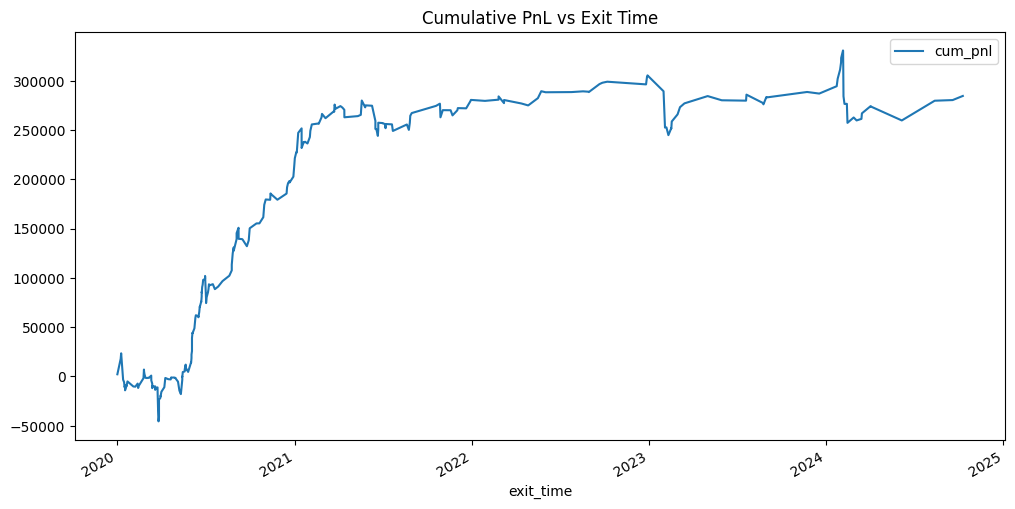

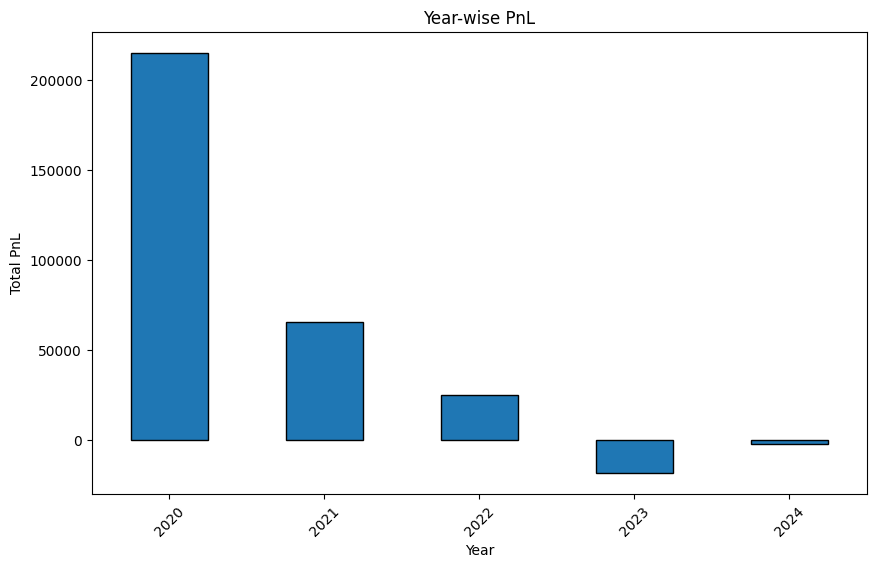

In [16]:
from lib import Bank, PositionManager, show_equity_curve
from bb_mean_rev import backtest

params = {
    'initial_capital': 500000,
    'max_positions': 5,
    'slippage': 0.001,
    'bb_period': 20,
    'bb_sd': 3.75,
    'start_date': '2020-01-01',
    'end_date': '2025-10-01',
}


bank = Bank(params['initial_capital'])
pm = PositionManager(bank, brokerage=0)

tearsheet, trades = backtest(df.copy(), pm, params, show_pb=True)
print(pd.DataFrame({
    "Metrics": tearsheet.keys(),
    "Values": tearsheet.values(),
}))
show_equity_curve(trades)

In [ ]:
# trades[(trades.exit_time > pd.Timestamp("2023-01-01")) & (trades.exit_time < pd.Timestamp("2023-06-01"))].to_csv("bb_mean_rev_trades.csv", index=False)
trades.to_csv("bb_mean_rev_trades.csv", index=False)

In [ ]:
((trades.exit_price - trades.avg_entry_price)/trades.avg_entry_price * 100).plot()

                      Metrics                    Values
0                      Period  2020-06-05 to 2020-12-30
1            Starting capital                    500000
2               Final capital                 802935.71
3                Total Trades                      3358
4                     Winners                      2264
5                      Losers                      1092
6               Profit factor                  1.356584
7       Active Position Count                         0
8   Max holding period (days)                         6
9   Avg holding period (days)                         0
10               Win Rate (%)                 67.421084
11               Total Profit                 302935.71
12                 Avg Profit                509.047951
13                   Avg Loss               -777.975137
14            Total Brokerage                       0.0
15                  Total Tax                  88672.02
16                  Total MTF                   

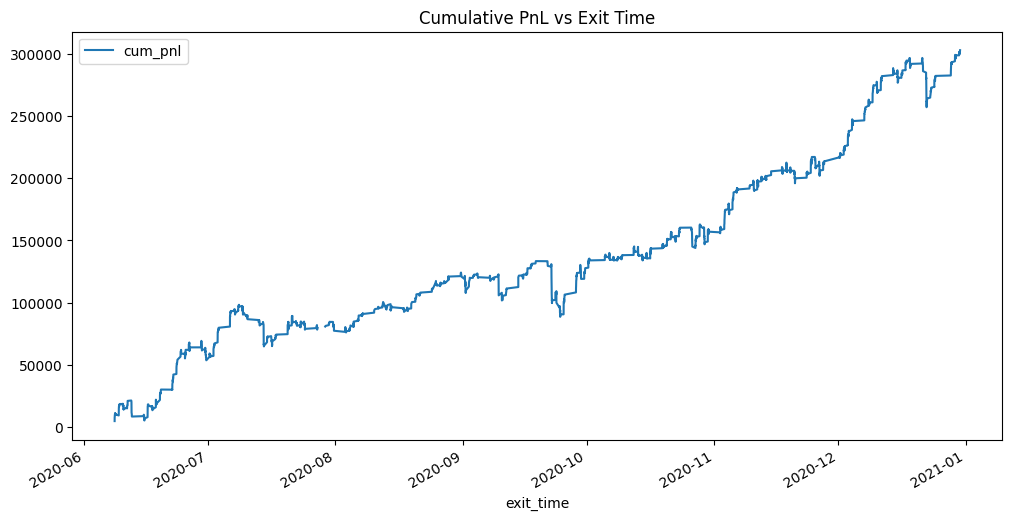

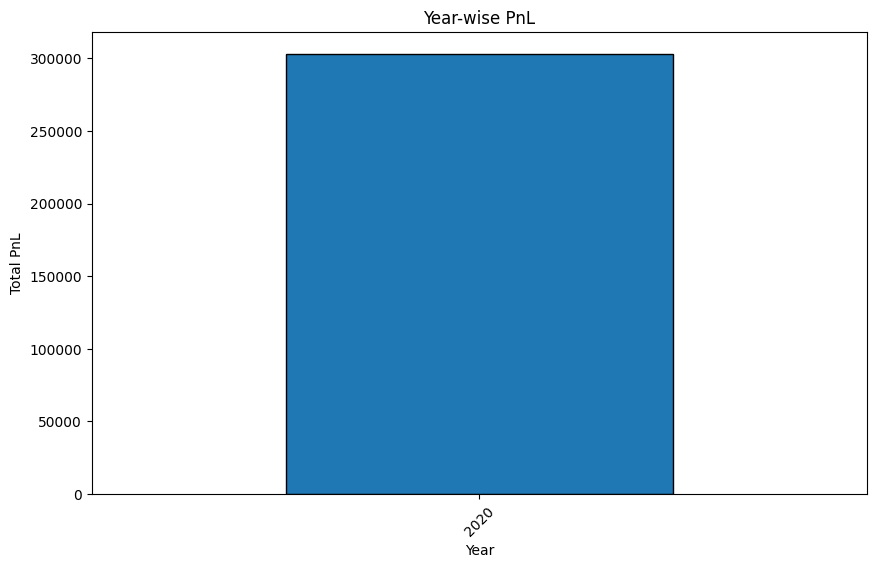

In [5]:
import os
import pandas as pd
from lib import show_equity_curve
from lib import Bank, PositionManager, show_equity_curve

def generate_tearsheet(initial_capital, pm: PositionManager, trades=None):
    if trades is None:
        trades = pm.get_trades()

    if len(trades) == 0:
        return {}, trades
    
    # Ensure entry_time and exit_time are datetime
    trades['entry_time'] = pd.to_datetime(trades['entry_time'])
    trades['exit_time'] = pd.to_datetime(trades['exit_time'])
    trades['returns'] = (trades['pnl'] / (trades['avg_entry_price'] * trades['quantity']))

    # Total trades
    total_trades = len(trades)

    # Win rate
    win_trades = (trades['pnl'] > 0).sum()
    win_rate = win_trades / total_trades * 100 if total_trades > 0 else 0

    # Profit
    total_profit = trades['pnl'].sum()
    avg_profit = trades[trades.pnl > 0].pnl.mean()
    avg_loss = trades[trades.pnl <= 0].pnl.mean()

    # Total tax
    total_tax = trades['tax'].sum()

    # Total brokerage
    total_brokerage = trades['brokerage'].sum()

    # MTF charge
    total_mtf_charge = trades['mtf_charge'].sum()

    # CAGR calculation
    start = trades['entry_time'].min()
    end = trades['exit_time'].max()
    years = (end - start).days / 365.25
    initial = initial_capital  # initial_capital from your code
    final = initial + total_profit
    cagr = ((final / initial) ** (1 / years) - 1) * 100 if years > 0 else None

    # Active positions
    active_position_count = 0
    if pm is not None:
        active_position_count = sum([len(p.trades) for p in pm.get_active_positions() if p is not None])

    # Period
    period = f"{start.strftime('%Y-%m-%d')} to {end.strftime('%Y-%m-%d')}"

    # Max holding period
    max_holding_period = (trades['exit_time'] - trades['entry_time']).max().days
    avg_holding_period = (trades['exit_time'] - trades['entry_time']).mean().days

    # Final capital
    final_capital = initial + total_profit


    # Calculate drawdown
    trades['cum_pnl'] = initial_capital + trades['pnl'].cumsum()

    trades['cum_max'] = trades['cum_pnl'].cummax()
    trades['drawdown'] = trades['cum_pnl'] - trades['cum_max']
    trades['drawdown_pct'] = trades['drawdown'] / trades['cum_max'] * 100
    avg_dd_perc = trades['drawdown_pct'].mean()
    max_drawdown = trades['drawdown'].min()
    max_drawdown_pct = abs(max_drawdown) / trades['cum_max'].max() * 100 if trades['cum_max'].max() != 0 else 0

    number_of_losses = len(trades[trades['pnl'] < 0])
    number_of_wins = len(trades[trades['pnl'] > 0])
    profit_factor = trades[trades['pnl'] > 0]['pnl'].sum() / abs(trades[trades['pnl'] < 0]['pnl'].sum()) if abs(trades[trades['pnl'] < 0]['pnl'].sum()) > 0 else None

    # Tearsheets summary
    tearsheet = {
        'Period': period,
        'Starting capital': initial_capital,
        'Final capital': final_capital,
        'Total Trades': total_trades,
        'Winners': number_of_wins,
        'Losers': number_of_losses,
        'Profit factor': profit_factor if profit_factor else "N/A",
        'Active Position Count': active_position_count,
        'Max holding period (days)': max_holding_period,
        'Avg holding period (days)': avg_holding_period,
        'Win Rate (%)': win_rate,
        'Total Profit': total_profit,
        'Avg Profit': avg_profit,
        'Avg Loss': avg_loss,
        'Total Brokerage': total_brokerage,
        'Total Tax': total_tax if total_tax else "N/A",
        'Total MTF': total_mtf_charge if total_mtf_charge else "N/A",
        'CAGR (%)': cagr if cagr else "N/A",
        'Max Drawdown': max_drawdown,
        'Max Drawdown (%)': max_drawdown_pct,
        'Avg Drawdown (%)': avg_dd_perc
    }
    
    return tearsheet, trades

dfs = []
for f in os.listdir("trades"):
    __df = pd.read_csv(os.path.join("trades", f))
    dfs.append(__df)
all_trades = pd.concat(dfs).reset_index(drop=True)
tearsheet, trades = generate_tearsheet(500000, None, all_trades)
print(pd.DataFrame({
    "Metrics": tearsheet.keys(),
    "Values": tearsheet.values(),
}))
show_equity_curve(all_trades)

In [ ]:
from fyers_helper import generate_wfo_splits, backtest_worker

splits = generate_wfo_splits(start_date='2020-01-01', end_date='2021-01-01', num_of_splits=4, insample_ratio_size=0.75, outsample_ratio_size=0.25)
splits

[{'is_start': '2020-01-01',
  'is_end': '2020-06-05',
  'oos_start': '2020-06-05',
  'oos_end': '2020-07-28'},
 {'is_start': '2020-02-22',
  'is_end': '2020-07-28',
  'oos_start': '2020-07-28',
  'oos_end': '2020-09-18'},
 {'is_start': '2020-04-14',
  'is_end': '2020-09-18',
  'oos_start': '2020-09-18',
  'oos_end': '2020-11-09'},
 {'is_start': '2020-06-05',
  'is_end': '2020-11-09',
  'oos_start': '2020-11-09',
  'oos_end': '2021-01-01'}]

In [27]:
from itertools import product
import numpy as np

def convert(obj):
    if isinstance(obj, np.int64):
        return int(obj)
    if isinstance(obj, np.float64):
        return float(obj)
    return obj

def create_param_sets(params, space):
    space_ranges = {}
    for key in space.keys():
        space_ranges[key] = np.arange(space[key]['low'], space[key]['high'], space[key]['step'])
        space_ranges[key] = [convert(v) for v in space_ranges[key]]

    param_combinations = [dict(zip(space_ranges.keys(), v)) for v in product(*space_ranges.values())]
    results = []
    for param_set in param_combinations:
        results.append({**params, **param_set})
    return results

def lambda_handler(event, context):
    params = event['params']
    space = event['space']
    param_sets = create_param_sets(params, space)
    return {
        'statusCode': 200,
        'body': param_sets
    }

payload = {
  "params": {
    "initial_capital": 500000,
    "max_positions": 5,
    "slippage": 0.001,
    "start_date": "2020-01-01",
    "end_date": "2025-10-01",
    "min_trade_num": 50,
    "show_pb": False,
    "brokerage": 0
  },
  "space": {
    "bb_period": {
      "type": "int",
      "low": 10,
      "high": 20,
      "step": 10
    },
    "bb_sd": {
      "type": "float",
      "low": 2,
      "high": 2.5,
      "step": 0.25
    }
  }
}

lambda_handler(payload, None)

{'statusCode': 200,
 'body': [{'initial_capital': 500000,
   'max_positions': 5,
   'slippage': 0.001,
   'start_date': '2020-01-01',
   'end_date': '2025-10-01',
   'min_trade_num': 50,
   'show_pb': False,
   'brokerage': 0,
   'bb_period': 10,
   'bb_sd': 2.0},
  {'initial_capital': 500000,
   'max_positions': 5,
   'slippage': 0.001,
   'start_date': '2020-01-01',
   'end_date': '2025-10-01',
   'min_trade_num': 50,
   'show_pb': False,
   'brokerage': 0,
   'bb_period': 10,
   'bb_sd': 2.25}]}

In [ ]:
import pandas as pd
import s3fs
from fyers_helper import ( backtest_worker, calc_performance, PositionManager, generate_tearsheet )
import datetime as dt
import talib as ta
from tqdm.notebook import tqdm
import numpy as np
from copy import copy


def backtest(_df, pm: PositionManager, params, show_pb=False):
    max_positions = params['max_positions']
    slippage = params['slippage']
    bb_period = int(params['bb_period'])
    bb_sd = round(params['bb_sd'], 2)
    start_date = params['start_date']
    end_date = params['end_date']
    initial_capital = params['initial_capital']

    print(f"Params: max_positions={max_positions}, bb_period={bb_period}, bb_sd={bb_sd}")

    def calc_bbands(group):
        group = group.copy()
        group['upper_band'], group['middle_band'], group['lower_band'] = ta.BBANDS(
            group['Close'],
            timeperiod=bb_period,     # window size for moving average
            nbdevup=bb_sd,         # number of stdevs for upper band
            nbdevdn=bb_sd,         # number of stdevs for lower band
            matype=0           # MA_Type.SMA (0), EMA (1), etc.
        )
        return group
    
    def calc_aroon(group):
        group = group.copy()
        group = group.set_index('Date')
        resampled = group.resample('4h').agg({
            'High': 'max',
            'Low': 'min'
        })
        aroon_up, aroon_down = ta.AROON(resampled.High, resampled.Low, timeperiod=14)
        group['aroon_up'] = aroon_up.reindex(group.index, method='ffill')
        group = group.reset_index()
        return group
    

    _df = _df[(_df.Date >= start_date) & (_df.Date < end_date)].reset_index()

    _df = _df.groupby('Stock', group_keys=False).apply(calc_bbands)
    # _df = _df.groupby('Stock', group_keys=False).apply(calc_aroon)
    _df['close_below_lower_bb'] = np.where(_df.Close < _df.lower_band, 1, 0)
    _df['exit_price'] = _df.groupby('Stock')['Open'].shift(-1)
    _df['close_below_lower_bb_2'] = _df.groupby('Stock')['close_below_lower_bb'].shift(2)
    _df['close_below_lower_bb_1'] = _df.groupby('Stock')['close_below_lower_bb'].shift(1)


    signals = (
        _df[
            (_df.close_below_lower_bb_1 == 1) & 
            (_df.close_below_lower_bb_2 == 1) & 
            (_df.close_below_lower_bb == 1) #&
            # (_df.aroon_up > 90)
        ].reset_index(drop=True)
    )


    if show_pb:
        pb = tqdm(total=_df.Date.nunique(), desc="Backtesting...")

    for idx, group in _df.groupby('Date'):
        for position in pm.get_active_positions():
            stock = group[group.Stock == position.stock]
            if len(stock) < 1:
                continue
            try:
                if (stock.Close.iloc[0] >= stock.middle_band.iloc[0]):# or (stock.Close.iloc[0] - position.avg_entry_price)/position.avg_entry_price * 100 <= -5:
                    pm.close_position(position.stock, idx, stock.exit_price.iloc[0] * (1 - slippage))

            except Exception as e:
                print(f"stock.Close - {stock.Close}")
                print(f"stock - {stock}")
                print(f"position - {position}")
                print(f"idx - {idx}")
                print(f"group - {group}")
                raise e
        
        day_signals = signals[signals.Date == idx]
        for signal in day_signals.itertuples():
            if pm.get_position(signal.Stock) is None and len(pm.get_active_positions()) < max_positions:
                capital = round(pm.bank.capital_available / (max_positions - len(pm.get_active_positions())), 2)
                position = pm.new_position(signal.Stock, idx, signal.exit_price * (1 + slippage), capital)

        if show_pb:
            pb.update(1)

    if show_pb:
        pb.close()

    return generate_tearsheet(initial_capital, pm)


def read_parquet(file) -> pd.DataFrame:
    fs = s3fs.S3FileSystem()
    with fs.open(file, 'rb') as f:
        return pd.read_parquet(f)

def lambda_handler(event, context):
    df = read_parquet('nifty200_5m.parquet')
    args = (1, backtest, df, event)
    _, tearsheet, trades = backtest_worker(args)
    perf = calc_performance(tearsheet, trades, event["min_trade_num"])
    event_copy = copy(event)
    event_copy["perf"] = perf
    return {
        'statusCode': 200,
        'body': event_copy
    }

param = {
        "initial_capital": 500000,
        "max_positions": 5,
        "slippage": 0.001,
        "start_date": "2020-01-01",
        "end_date": "2020-02-01",
        "min_trade_num": 50,
        "show_pb": False,
        "brokerage": 0,
        "bb_period": 10,
        "bb_sd": 2
      }
lambda_handler(param, None)

Params: max_positions=5, bb_period=10, bb_sd=2


{'statusCode': 200,
 'body': {'initial_capital': 500000,
  'max_positions': 5,
  'slippage': 0.001,
  'start_date': '2020-01-01',
  'end_date': '2020-02-01',
  'min_trade_num': 50,
  'show_pb': False,
  'brokerage': 0,
  'bb_period': 10,
  'bb_sd': 2,
  'perf': np.float64(-10.12852538662454)}}

In [5]:
import pandas as pd
import os

def file_splitter(file_path, num_splits=4, overlap=True):
    if file_path.startswith("s3://"):
        import s3fs
        fs = s3fs.S3FileSystem()
        with fs.open(file_path, 'rb') as f:
            df = pd.read_parquet(f)
    else:
        df = pd.read_parquet(file_path)
    
    df['Date'] = pd.to_datetime(df['Date'])
    min_date = df['Date'].min()
    max_date = df['Date'].max()
    total_days = (max_date - min_date).days
    split_days = total_days // num_splits
    splits = []
    
    dir_name = f"{os.path.dirname(file_path)}/data_splits"
    if not file_path.startswith("s3://"):
        dir_name = f"{os.path.dirname(os.path.abspath(file_path))}/data_splits"
        os.makedirs(dir_name, exist_ok=True, mode=0o755)

    for i in range(num_splits):
        start_date = min_date + pd.Timedelta(days=i * split_days)
        end_date = start_date + pd.Timedelta(days=split_days)
        if i == num_splits - 1:
            end_date = max_date
        if overlap and i > 0:
            start_date -= pd.Timedelta(days=split_days // 10)  # 10% overlap
        
        file_name = f"{dir_name}/{start_date:%Y-%m-%dT%H:%M:%S}_{end_date:%Y-%m-%dT%H:%M:%S}.parquet"
        df[(df['Date'] >= start_date) & (df['Date'] < end_date)].to_parquet(file_name, index=False)
        splits.append(file_name)
    return splits

file_splitter("nifty200_5m.parquet", num_splits=4)


['/Users/abhilashnanda/code/strategy-notebooks/notebooks/data_splits/2020-01-01T09:15:00_2021-06-11T09:15:00.parquet',
 '/Users/abhilashnanda/code/strategy-notebooks/notebooks/data_splits/2021-04-20T09:15:00_2022-11-20T09:15:00.parquet',
 '/Users/abhilashnanda/code/strategy-notebooks/notebooks/data_splits/2022-09-29T09:15:00_2024-04-30T09:15:00.parquet',
 '/Users/abhilashnanda/code/strategy-notebooks/notebooks/data_splits/2024-03-09T09:15:00_2025-10-10T15:15:00.parquet']

In [20]:
from typing import Callable
import os
import pandas as pd
import s3fs

def read_parquet(file) -> pd.DataFrame:
    fs = s3fs.S3FileSystem()
    with fs.open(file, 'rb') as f:
        return pd.read_parquet(f)

def market_data_iterator(dir_name, from_date=None, to_date=None, transformer: Callable[[pd.DataFrame], pd.DataFrame]=None):
    from_date = pd.to_datetime(from_date) if from_date else None
    to_date = pd.to_datetime(to_date) if to_date else None
    if dir_name.startswith("s3://"):
        import s3fs
        fs = s3fs.S3FileSystem()
        files = fs.ls(dir_name)
        files = [f for f in files if f.endswith('.parquet')]
    else:
        files = [f for f in os.listdir(dir_name) if f.endswith('.parquet')]

    files = sorted(files)
    selected_files = []
    for file in files:
        start_str, end_str = file.replace('.parquet', '').split('_')
        start_date = pd.to_datetime(start_str)
        end_date = pd.to_datetime(end_str)
        if (from_date <= start_date <= to_date) or (from_date <= end_date <= to_date):
            selected_files.append(file)

    last_date = None
    for file in selected_files:
        print(f"Processing file: {file}")
        if dir_name.startswith("s3://"):
            _df = read_parquet(file)
        else:
            _df = pd.read_parquet(os.path.join(dir_name, file))
        
        if transformer:
            _df = transformer(_df, from_date, to_date)

        grouper = _df.groupby('Date') if last_date is None else _df[_df.Date > last_date].groupby('Date')

        for idx, group in grouper:
            if from_date <= idx < to_date:
                yield idx, group
                last_date = idx
            
            if idx >= to_date:
                break


In [21]:
import talib as ta
import numpy as np

def transformer(bb_period=20, bb_sd=3.75):
    def wrap(_df, start_date, end_date):
        def calc_bbands(group):
            group['upper_band'], group['middle_band'], group['lower_band'] = ta.BBANDS(
                group['Close'],
                timeperiod=bb_period,     # window size for moving average
                nbdevup=bb_sd,         # number of stdevs for upper band
                nbdevdn=bb_sd,         # number of stdevs for lower band
                matype=0           # MA_Type.SMA (0), EMA (1), etc.
            )
            return group

        _df = _df[(_df.Date >= start_date) & (_df.Date < end_date)].reset_index()

        _df = _df.groupby('Stock', group_keys=False).apply(calc_bbands)
        _df['close_below_lower_bb'] = np.where(_df.Close < _df.lower_band, 1, 0)
        _df['exit_price'] = _df.groupby('Stock')['Open'].shift(-1)
        _df['close_below_lower_bb_2'] = _df.groupby('Stock')['close_below_lower_bb'].shift(2)
        _df['close_below_lower_bb_1'] = _df.groupby('Stock')['close_below_lower_bb'].shift(1)
        return _df
    return wrap


for idx, data in market_data_iterator(
    "/Users/abhilashnanda/code/strategy-notebooks/notebooks/data_splits",
    from_date="2020-01-01",
    to_date="2020-03-01",
    transformer=transformer(bb_period=20, bb_sd=3.75)
):
    print(data.head(1).head(1))

Processing file: 2020-01-01T09:15:00_2021-06-11T09:15:00.parquet


/var/folders/rw/xc9yc4151v3_3lcv8h2n7pxr0000gn/T/ipykernel_2506/3399065858.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _df = _df.groupby('Stock', group_keys=False).apply(calc_bbands)


   index       Stock                Date     Open     High     Low   Close  \
0      0  NSE:ABB-EQ 2020-01-01 09:15:00  1296.95  1296.95  1275.0  1278.0   

   Volume  upper_band  middle_band  lower_band  close_below_lower_bb  \
0      42         NaN          NaN         NaN                     0   

   exit_price  close_below_lower_bb_2  close_below_lower_bb_1  
0      1278.0                     NaN                     NaN  
   index       Stock                Date    Open    High     Low   Close  \
1      1  NSE:ABB-EQ 2020-01-01 09:20:00  1278.0  1289.0  1276.1  1276.2   

   Volume  upper_band  middle_band  lower_band  close_below_lower_bb  \
1     110         NaN          NaN         NaN                     0   

   exit_price  close_below_lower_bb_2  close_below_lower_bb_1  
1      1276.2                     NaN                     0.0  
   index       Stock                Date    Open    High     Low    Close  \
2      2  NSE:ABB-EQ 2020-01-01 09:25:00  1276.2  1286.0  1276.2  1